In [1]:
import cupy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
import re
import seaborn as sns
import warnings
import os
warnings.filterwarnings('ignore')

In [2]:
# Function to process sqft
def process_sqft(x):
    if pd.isna(x):
        return np.nan
        
    x = str(x).strip().lower()
    
    # Check if it's a range (e.g., "1100-1200")
    if '-' in x:
        parts = x.split('-')
        try:
            # Calculate average of the range
            return (float(parts[0]) + float(parts[1])) / 2
        except:
            return np.nan
    
    # Extract numeric part and unit
    match = re.search(r'(\d+(?:\.\d+)?)\s*([a-zA-Z\.\s]+)?', x)
    if not match:
        try:
            return float(x)
        except:
            return np.nan
    
    value = float(match.group(1))
    unit = match.group(2).strip() if match.group(2) else "sq.ft"
    
    # Convert to sq.ft based on unit
    if 'meter' in unit or 'metre' in unit:
        return value * 10.764
    elif 'perch' in unit:
        return value * 272.25
    elif 'acre' in unit:
        return value * 43560
    elif 'yard' in unit:
        return value * 9
    else:  # Assume square feet
        return value


# Function to process size (bedroom count)
def extract_bedroom_count(x):
    if pd.isna(x):
        return np.nan
        
    x = str(x).strip().lower()
    match = re.search(r'(\d+)', x)
    if match:
        return float(match.group(1))
    return np.nan





Original dataset shape: (13320, 9)
- Processing total_sqft column

Sample of total_sqft conversions:
     total_sqft  total_sqft_processed
4282       3000                3000.0
7165       1364                1364.0
3335       1200                1200.0
1692        595                 595.0
6542       1504                1504.0
3120       1200                1200.0
3286       2700                2700.0
4370       1533                1533.0
5064       1050                1050.0
6332       1190                1190.0

- Processing size column

Sample of size conversions:
            size  bedroom_count
6503       3 BHK            3.0
12059  4 Bedroom            4.0
11529      2 BHK            2.0
3050       3 BHK            3.0
3652       3 BHK            3.0
2382   2 Bedroom            2.0
6735       3 BHK            3.0
3745   2 Bedroom            2.0
3000   5 Bedroom            5.0
5657       2 BHK            2.0

Missing values in each column:
              Missing Values  Percentage
a

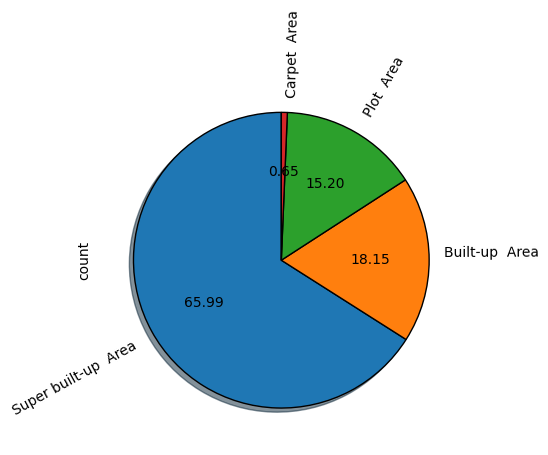

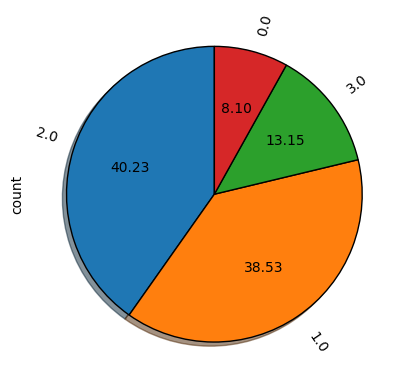

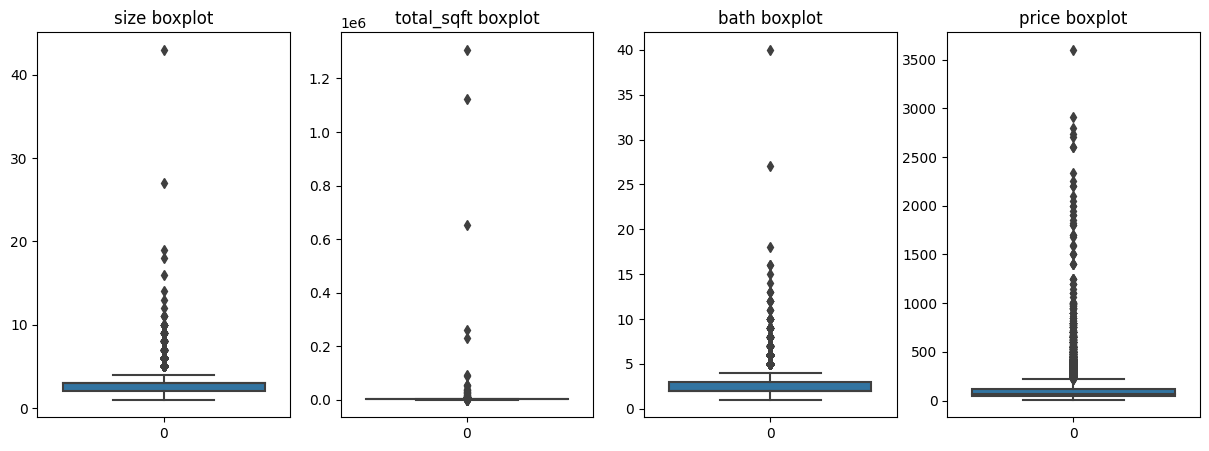

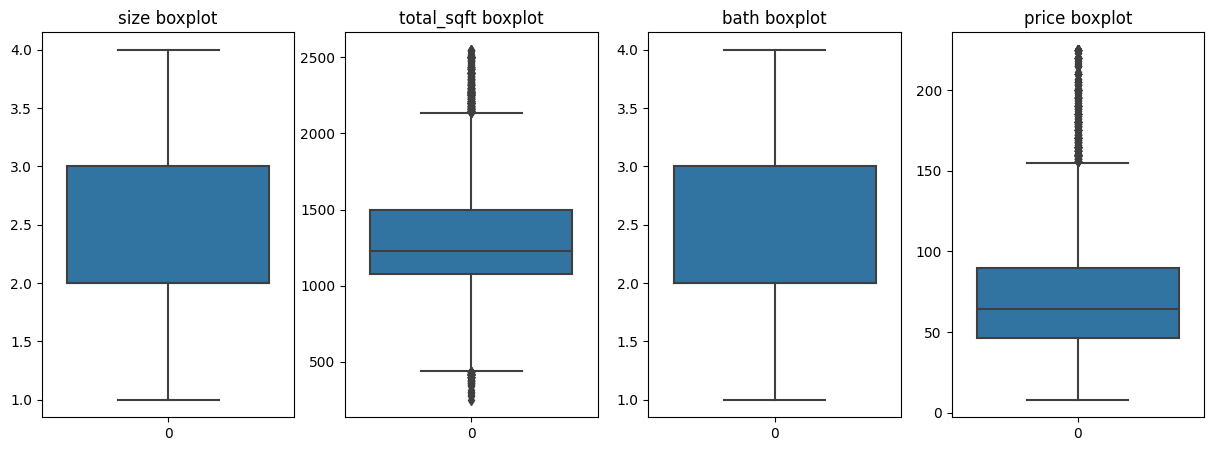

In [3]:
df = pd.read_csv('/kaggle/input/original-2-2/Bengaluru_House_Data.csv')
print(f"Original dataset shape: {df.shape}")

if 'total_sqft' in df.columns:
    print("- Processing total_sqft column")
    df['total_sqft_processed'] = df['total_sqft'].apply(process_sqft)
    
    # Display some examples of the conversion
    sample = df[['total_sqft', 'total_sqft_processed']].sample(min(10, len(df)))
    print("\nSample of total_sqft conversions:")
    print(sample)
    
    # Replace original column
    df['total_sqft'] = df['total_sqft_processed']
    df.drop('total_sqft_processed', axis=1, inplace=True)

# Process size (bedroom count)
if 'size' in df.columns:
    print("\n- Processing size column")
    df['bedroom_count'] = df['size'].apply(extract_bedroom_count)
    
    # Display some examples of the conversion
    sample = df[['size', 'bedroom_count']].sample(min(10, len(df)))
    print("\nSample of size conversions:")
    print(sample)
    
    # Replace original column
    df['size'] = df['bedroom_count']
    df.drop('bedroom_count', axis=1, inplace=True)


print("\nMissing values in each column:")
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_data = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})
print(missing_data)

# Drop columns with high percentage of missing values (e.g., >30%)
high_missing_cols = missing_data[missing_data['Percentage'] > 30].index.tolist()
if high_missing_cols:
    print(f"\nDropping columns with >30% missing values: {high_missing_cols}")
    df = df.drop(high_missing_cols, axis=1)

# Analyze the 'area_type' column
df['area_type'].value_counts().plot.pie(autopct='%.2f',shadow=True,startangle=90,wedgeprops={'edgecolor':'black'},rotatelabels=True)
plt.show()

# area_type have 4 categories out of which one is 66% and also probablity density function of
# all four category is almost same so droping this feature
df.drop(columns=['area_type'],inplace=True)


(df['availability'].value_counts()/df.shape[0])*100
# availability have 81 categories but one value is around 80% so this feature is not usefull
df.drop(columns=['availability'],inplace=True)

# fill missing values in location column with mode
df['location'] = df['location'].fillna(df['location'].mode()[0])
location_counts = df['location'].value_counts()
location_counts_less_than_10 = location_counts[location_counts <= 10]
df['location'] = df['location'].apply(lambda x: 'other' if x in location_counts_less_than_10 else x)
#perform one hot encoding on location column
df = pd.get_dummies(df, columns=['location'], drop_first=True)

# fill missing values in bath column with median
df['bath'] = df['bath'].fillna(df['bath'].median())

# fill the missing value in size column with mode
df['size'] = df['size'].fillna(df['size'].mode()[0])

df['balcony'].value_counts().plot.pie(autopct='%.2f',shadow=True,startangle=90,wedgeprops={'edgecolor':'black'},rotatelabels=True)
plt.show()

df.drop(columns=['balcony'],inplace=True)


numerical_cols=['size','total_sqft','bath','price']
categorical_cols=['location']

# Check for outliers in numerical columns
plt.figure(figsize=(15, 5))
for i, col in enumerate(numerical_cols):
    plt.subplot(1, len(numerical_cols), i+1)
    sns.boxplot(df[col])
    plt.title(f"{col} boxplot")
plt.show()

# Remove outliers in numerical columns using IQR method
Q1 = df[numerical_cols].quantile(0.25)
Q3 = df[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

outliers = (df[numerical_cols] < (Q1 - 1.5 * IQR)) | (df[numerical_cols] > (Q3 + 1.5 * IQR))
df = df[~outliers.any(axis=1)]

# Check for outliers in numerical columns after removing outliers
plt.figure(figsize=(15, 5))
for i, col in enumerate(numerical_cols):
    plt.subplot(1, len(numerical_cols), i+1)
    sns.boxplot(df[col])
    plt.title(f"{col} boxplot")
plt.show()


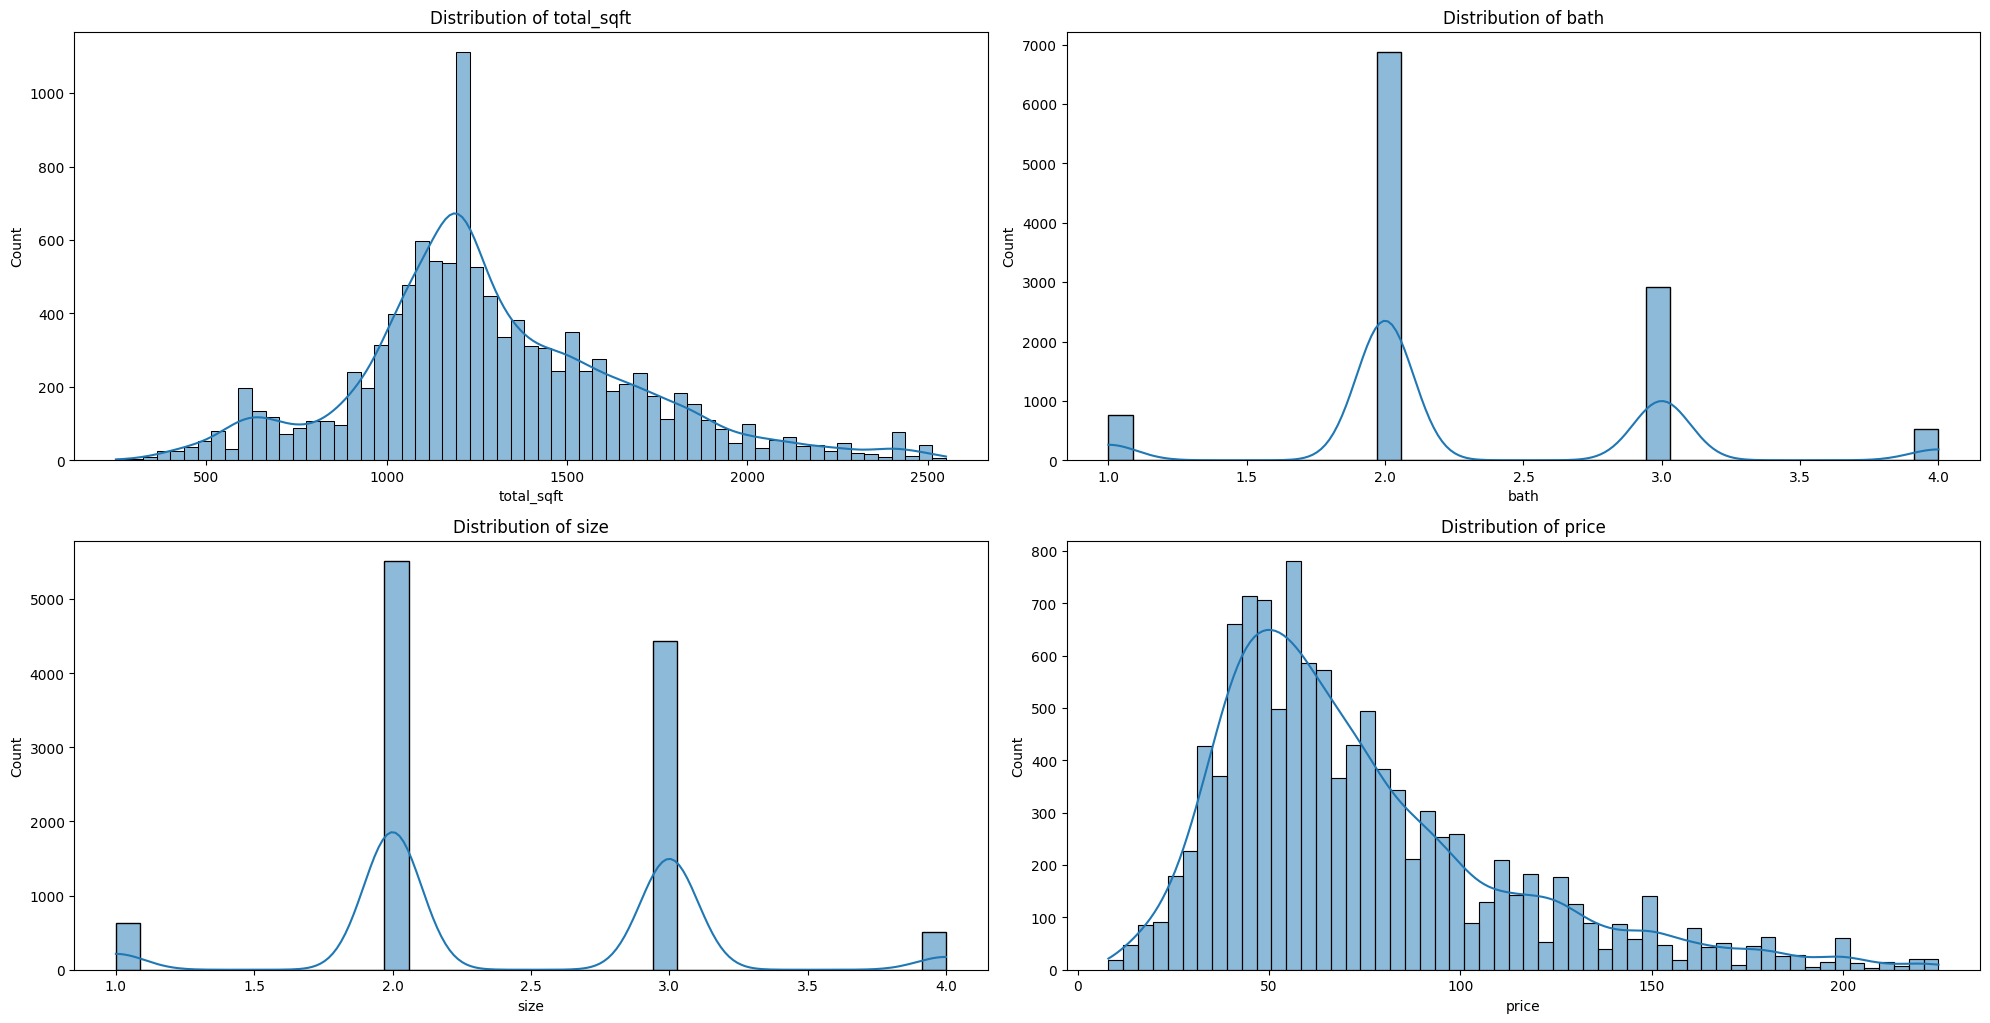

In [4]:
# Plot numerical attributes
numerical_cols = ['total_sqft', 'bath', 'size', 'price']
plt.figure(figsize=(20, 15))
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 2, i+1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


In [5]:

# Save the updated cleansed dataset to a new CSV file
cleansed_csv_path = 'cleaned_real_estate_data_with_encoding.csv'
df.to_csv(cleansed_csv_path, index=False)
print(f"Saved cleansed dataset with one-hot encoding to '{cleansed_csv_path}'")

Saved cleansed dataset with one-hot encoding to 'cleaned_real_estate_data_with_encoding.csv'


In [6]:
class ActivationFunction:
    class Sigmoid:
        def forward(self, x):
            return 1 / (1 + cp.exp(-x))
        def derivative(self, x):
            s = self.forward(x)
            return s * (1 - s)
    
    class Tanh:
        def forward(self, x):
            return cp.tanh(x)
        def derivative(self, x):
            return 1 - cp.square(cp.tanh(x))
    
    class ReLU:
        def forward(self, x):
            return cp.maximum(0, x)
        def derivative(self, x):
            return cp.where(x > 0, 1.0, 0.0)


class Layer:
    def __init__(self, input_size, output_size, activation):
        self.weights = cp.random.randn(output_size, input_size) * cp.sqrt(2 / input_size)
        self.biases = cp.zeros((output_size, 1))
        self.activation = activation
        self.dw = None
        self.db = None
    
    def forward(self, x):
        self.a_prev = x
        self.z = cp.dot(self.weights, x) + self.biases
        self.a = self.activation.forward(self.z)
        return self.a
    
    def backward(self, grad):
        delta = grad * self.activation.derivative(self.z)
        self.dw = cp.dot(delta, self.a_prev.T)
        self.db = cp.sum(delta, axis=1, keepdims=True)
        grad_prev = cp.dot(self.weights.T, delta)
        return grad_prev


class Optimizer:
    class SGD:
        def __init__(self, learning_rate):
            self.learning_rate = learning_rate
        
        def update(self, layers):
            for layer in layers:
                layer.weights -= self.learning_rate * layer.dw
                layer.biases -= self.learning_rate * layer.db
    
    class BatchGradientDescent:
        def __init__(self, learning_rate):
            self.learning_rate = learning_rate
        
        def update(self, layers):
            for layer in layers:
                layer.weights -= self.learning_rate * layer.dw
                layer.biases -= self.learning_rate * layer.db
    
    class MiniBatchGradientDescent:
        def __init__(self, learning_rate, batch_size):
            self.learning_rate = learning_rate
            self.batch_size = batch_size
        
        def update(self, layers):
            for layer in layers:
                layer.weights -= self.learning_rate * layer.dw
                layer.biases -= self.learning_rate * layer.db


class LossFunction:
    class MeanSquaredError:
        def compute(self, y_true, y_pred):
            return cp.mean(cp.square(y_true - y_pred))
        def derivative(self, y_true, y_pred):
            return -2 * (y_true - y_pred) / y_true.size
    
    class RootMeanSquaredError:
        def compute(self, y_true, y_pred):
            return cp.sqrt(cp.mean(cp.square(y_true - y_pred)))
        def derivative(self, y_true, y_pred):
            mse = cp.mean(cp.square(y_true - y_pred))
            return -(y_true - y_pred) / (y_true.size * cp.sqrt(mse))
    
    class RSquared:
        def compute(self, y_true, y_pred):
            ss_res = cp.sum(cp.square(y_true - y_pred))
            ss_tot = cp.sum(cp.square(y_true - cp.mean(y_true)))
            return 1 - (ss_res / ss_tot)
        def derivative(self, y_true, y_pred):
            ss_res = cp.sum(cp.square(y_true - y_pred))
            ss_tot = cp.sum(cp.square(y_true - cp.mean(y_true)))
            return -2 * (y_true - y_pred) / ss_tot


class DataLoader:
    def __init__(self, X, y, batch_size):
        self.X = cp.array(X)
        self.y = cp.array(y)
        self.batch_size = batch_size
        self.n_samples = self.X.shape[0]
    
    def get_batch(self):
        indices = cp.arange(self.n_samples)
        cp.random.shuffle(indices)
        for i in range(0, self.n_samples, self.batch_size):
            batch_indices = indices[i:i+self.batch_size]
            yield self.X[batch_indices], self.y[batch_indices]
    
    def get_full_batch(self):
        return self.X, self.y


class MLP:
    def __init__(self, layer_sizes, activation, optimizer_type, learning_rate, batch_size=32):
        self.layers = []
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        activation_map = {
            'sigmoid': ActivationFunction.Sigmoid(),
            'tanh': ActivationFunction.Tanh(),
            'relu': ActivationFunction.ReLU()
        }
        act = activation_map[activation]
        
        for i in range(len(layer_sizes)-1):
            self.layers.append(Layer(layer_sizes[i], layer_sizes[i+1], act))
        
        if optimizer_type == 'sgd':
            self.optimizer = Optimizer.SGD(learning_rate)
            self.batch_size = 1
        elif optimizer_type == 'batch':
            self.optimizer = Optimizer.BatchGradientDescent(learning_rate)
            self.use_full_batch = True
        elif optimizer_type == 'mini_batch':
            self.optimizer = Optimizer.MiniBatchGradientDescent(learning_rate, batch_size)
            self.use_full_batch = False
        
        self.loss_history = []
        self.val_loss_history = []
    
    def forward(self, x):
        self.a_prev = x
        for layer in self.layers:
            self.a_prev = layer.forward(self.a_prev)
        return self.a_prev
    
    def backward(self, y_true, y_pred, loss_function):
        if loss_function == 'mse':
            grad = LossFunction.MeanSquaredError().derivative(y_true, y_pred)
        elif loss_function == 'rmse':
            grad = LossFunction.RootMeanSquaredError().derivative(y_true, y_pred)
        elif loss_function == 'r2':
            grad = LossFunction.RSquared().derivative(y_true, y_pred)
        else:
            raise ValueError("Invalid loss function. Use 'mse', 'rmse', or 'r2'.")
        
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
    
    def train(self, X_train, y_train, X_val=None, y_val=None, epochs=100, loss_function='mse'):
        data_loader = DataLoader(X_train, y_train, self.batch_size)
        
        for epoch in range(epochs):
            epoch_losses = []
            
            if hasattr(self, 'use_full_batch') and self.use_full_batch:
                # Batch Gradient Descent (full batch)
                X_batch, y_batch = data_loader.get_full_batch()
                y_batch = y_batch.reshape(y_batch.shape[0], 1)
                
                y_pred = self.forward(X_batch.T)
                
                if loss_function == 'mse':
                    loss = LossFunction.MeanSquaredError().compute(y_batch.T, y_pred)
                elif loss_function == 'rmse':
                    loss = LossFunction.RootMeanSquaredError().compute(y_batch.T, y_pred)
                elif loss_function == 'r2':
                    loss = LossFunction.RSquared().compute(y_batch.T, y_pred)
                
                epoch_losses.append(float(loss))
                
                self.backward(y_batch.T, y_pred, loss_function)
                self.optimizer.update(self.layers)
            else:
                # SGD or Mini-batch Gradient Descent
                for X_batch, y_batch in data_loader.get_batch():
                    y_batch = y_batch.reshape(y_batch.shape[0], 1)
                    
                    y_pred = self.forward(X_batch.T)
                    
                    if loss_function == 'mse':
                        loss = LossFunction.MeanSquaredError().compute(y_batch.T, y_pred)
                    elif loss_function == 'rmse':
                        loss = LossFunction.RootMeanSquaredError().compute(y_batch.T, y_pred)
                    elif loss_function == 'r2':
                        loss = LossFunction.RSquared().compute(y_batch.T, y_pred)
                    
                    epoch_losses.append(float(loss))
                    
                    self.backward(y_batch.T, y_pred, loss_function)
                    self.optimizer.update(self.layers)
            
            avg_loss = np.mean(epoch_losses)
            self.loss_history.append(avg_loss)
            
            if X_val is not None and y_val is not None:
                y_val_shaped = y_val.reshape(y_val.shape[0], 1)
                val_pred = self.forward(cp.array(X_val).T)
                if loss_function == 'mse':
                    val_loss = LossFunction.MeanSquaredError().compute(cp.array(y_val_shaped).T, val_pred)
                elif loss_function == 'rmse':
                    val_loss = LossFunction.RootMeanSquaredError().compute(cp.array(y_val_shaped).T, val_pred)
                elif loss_function == 'r2':
                    val_loss = LossFunction.RSquared().compute(cp.array(y_val_shaped).T, val_pred)
                self.val_loss_history.append(float(val_loss))
            
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_loss:.4f}", end="")
                if X_val is not None:
                    print(f", Val Loss: {float(val_loss):.4f}")
                else:
                    print()
    
    def predict(self, X):
        return self.forward(cp.array(X).T).T

(11095, 244)
241
(7766, 244)
(7766, 244)
Training: lr=0.001, epochs=20, arch=[244, 64, 1], activation=relu, optimizer=sgd, batch_size=32
Epoch 10/20, Train Loss: 663.4682, Val Loss: 712.1760
Epoch 20/20, Train Loss: 734.8433, Val Loss: 899.7785

Final Evaluation Metrics for lr=0.001, epochs=20:
MSE: 922.4527830836198
RMSE: 30.37190779459894
R²: 0.40564630083659126
--------------------------------------------------
Training: lr=0.001, epochs=20, arch=[244, 64, 1], activation=relu, optimizer=batch, batch_size=32
Epoch 10/20, Train Loss: 6452.0339, Val Loss: 6883.1659
Epoch 20/20, Train Loss: 3974.6489, Val Loss: 3726.5763

Final Evaluation Metrics for lr=0.001, epochs=20:
MSE: 3673.3975973062425
RMSE: 60.6085604292516
R²: -1.3668392469460722
--------------------------------------------------
Training: lr=0.001, epochs=20, arch=[244, 64, 1], activation=relu, optimizer=mini_batch, batch_size=32
Epoch 10/20, Train Loss: 533.5692, Val Loss: 593.5190
Epoch 20/20, Train Loss: 511.7848, Val Los

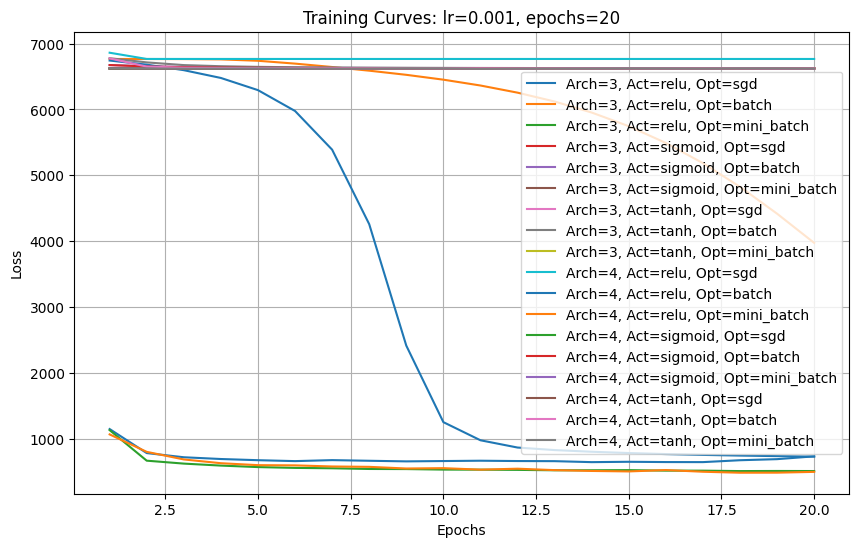

Training: lr=0.001, epochs=30, arch=[244, 64, 1], activation=relu, optimizer=sgd, batch_size=32
Epoch 10/30, Train Loss: 660.7473, Val Loss: 845.9298
Epoch 20/30, Train Loss: 649.5060, Val Loss: 640.8988
Epoch 30/30, Train Loss: 639.2486, Val Loss: 733.7828

Final Evaluation Metrics for lr=0.001, epochs=30:
MSE: 697.8309824152025
RMSE: 26.41649072861879
R²: 0.5503743569369082
--------------------------------------------------
Training: lr=0.001, epochs=30, arch=[244, 64, 1], activation=relu, optimizer=batch, batch_size=32
Epoch 10/30, Train Loss: 6336.9806, Val Loss: 6740.8962
Epoch 20/30, Train Loss: 3565.8610, Val Loss: 3297.3471
Epoch 30/30, Train Loss: 1120.1046, Val Loss: 1062.4105

Final Evaluation Metrics for lr=0.001, epochs=30:
MSE: 1098.1070698359765
RMSE: 33.13769862009093
R²: 0.2924689360763296
--------------------------------------------------
Training: lr=0.001, epochs=30, arch=[244, 64, 1], activation=relu, optimizer=mini_batch, batch_size=32
Epoch 10/30, Train Loss: 536

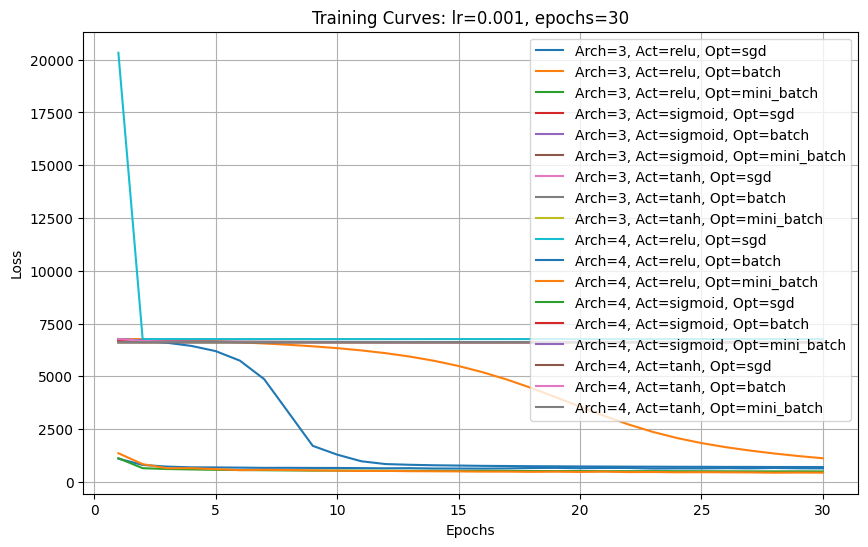

Training: lr=0.01, epochs=20, arch=[244, 64, 1], activation=relu, optimizer=sgd, batch_size=32
Epoch 10/20, Train Loss: 6766.4575, Val Loss: 7321.3311
Epoch 20/20, Train Loss: 6766.4575, Val Loss: 7321.3311

Final Evaluation Metrics for lr=0.01, epochs=20:
MSE: 7161.222005630631
RMSE: 84.62400372016577
R²: -3.61411019363919
--------------------------------------------------
Training: lr=0.01, epochs=20, arch=[244, 64, 1], activation=relu, optimizer=batch, batch_size=32
Epoch 10/20, Train Loss: 1477.3169, Val Loss: 2222.0478
Epoch 20/20, Train Loss: 1355.5274, Val Loss: 3550.6317

Final Evaluation Metrics for lr=0.01, epochs=20:
MSE: 3426.819046907914
RMSE: 58.539038657189394
R²: -1.2079640435197385
--------------------------------------------------
Training: lr=0.01, epochs=20, arch=[244, 64, 1], activation=relu, optimizer=mini_batch, batch_size=32
Epoch 10/20, Train Loss: 600.6344, Val Loss: 662.3360
Epoch 20/20, Train Loss: 516.0383, Val Loss: 589.0130

Final Evaluation Metrics for l

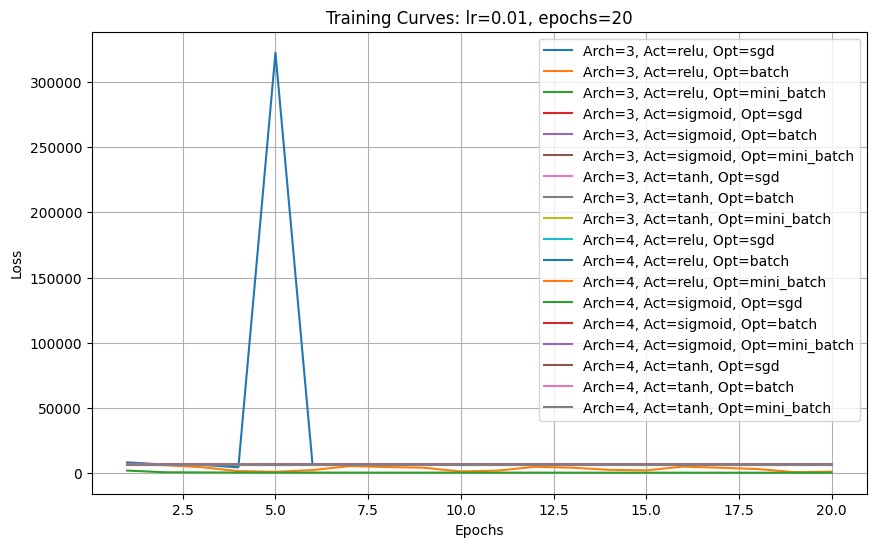

Training: lr=0.01, epochs=30, arch=[244, 64, 1], activation=relu, optimizer=sgd, batch_size=32
Epoch 10/30, Train Loss: 6766.4575, Val Loss: 7321.3311
Epoch 20/30, Train Loss: 6766.4575, Val Loss: 7321.3311
Epoch 30/30, Train Loss: 6766.4575, Val Loss: 7321.3311

Final Evaluation Metrics for lr=0.01, epochs=30:
MSE: 7161.222005630631
RMSE: 84.62400372016577
R²: -3.61411019363919
--------------------------------------------------
Training: lr=0.01, epochs=30, arch=[244, 64, 1], activation=relu, optimizer=batch, batch_size=32
Epoch 10/30, Train Loss: 5789.9815, Val Loss: 5259.6807
Epoch 20/30, Train Loss: 1808.5277, Val Loss: 1746.4723
Epoch 30/30, Train Loss: 762.0298, Val Loss: 744.7338

Final Evaluation Metrics for lr=0.01, epochs=30:
MSE: 767.3953861271721
RMSE: 27.70190221134953
R²: 0.5055527016342998
--------------------------------------------------
Training: lr=0.01, epochs=30, arch=[244, 64, 1], activation=relu, optimizer=mini_batch, batch_size=32
Epoch 10/30, Train Loss: 565.04

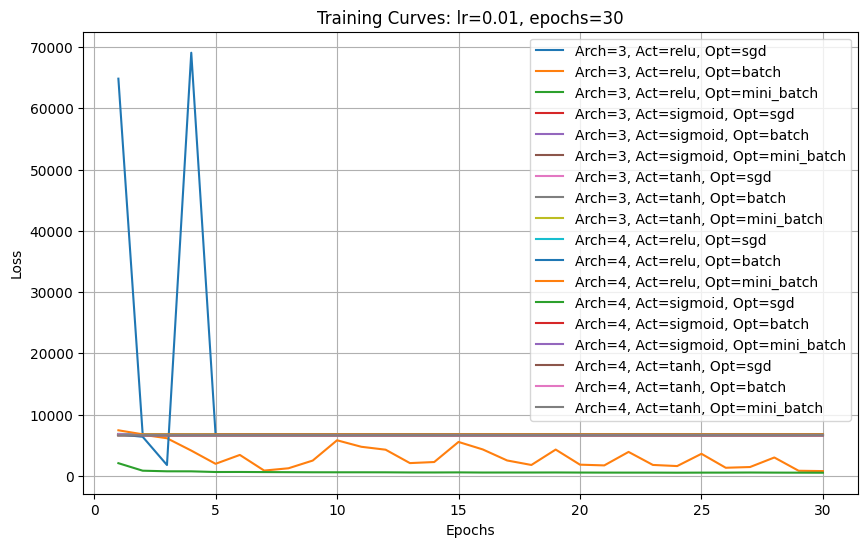

In [7]:

# # Load data
# file_path = 'cleaned_real_estate_data_with_encoding.csv'
# df = pd.read_csv(file_path)
X = df.drop(columns=['price'])
y = df['price']
print(X.shape)
numerical_cols = ['total_sqft', 'bath', 'size']
location_cols = [col for col in df.columns if 'location_' in col]
one_hot_cols = location_cols  
print(len(one_hot_cols))
# Create a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  # Scale numerical columns
        ('one_hot', 'passthrough', one_hot_cols) 
    ])

# split into train , test and val based on 70:15:15 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Convert one-hot encoded columns to integers
X_train[one_hot_cols] = X_train[one_hot_cols].astype('int8')
X_val[one_hot_cols] = X_val[one_hot_cols].astype('int8')
X_test[one_hot_cols] = X_test[one_hot_cols].astype('int8')


# Fit and transform the data
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

print(X_train.shape)


# Convert data to CuPy arrays
X_train = cp.array(X_train)
X_val = cp.array(X_val)
X_test = cp.array(X_test)
y_train = cp.array(y_train.values.reshape(-1, 1))
y_val = cp.array(y_val.values.reshape(-1, 1))
y_test = cp.array(y_test.values.reshape(-1, 1))

print(X_train.shape)

import matplotlib.pyplot as plt

# Define hyperparameters
learning_rates = [0.001, 0.01]
epochs_list = [20, 30]
architectures = [
    [X_train.shape[1], 64, 1],             # Two hidden layers
    [X_train.shape[1], 128, 64, 1]    # Three hidden layers
]
activations = ['relu', 'sigmoid', 'tanh']
optimizers = ['sgd', 'batch', 'mini_batch']
batch_sizes = [32]

# Metrics calculation function
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2
    }

# Experimentation
results = []

# Grouped plots for combinations of epochs and learning rates
for lr in learning_rates:
    for epochs in epochs_list:
        plt.figure(figsize=(10, 6))
        for arch in architectures:
            for activation in activations:
                for optimizer in optimizers:
                    for batch_size in batch_sizes:
                        print(f"Training: lr={lr}, epochs={epochs}, arch={arch}, activation={activation}, optimizer={optimizer}, batch_size={batch_size}")
                        
                        # Initialize MLP with correct optimizer type
                        mlp = MLP(
                            layer_sizes=arch,
                            activation=activation,
                            optimizer_type=optimizer,
                            learning_rate=lr,
                            batch_size=batch_size
                        )
                        
                        # Train MLP
                        mlp.train(X_train, y_train, X_val, y_val, epochs=epochs, loss_function='mse')
                        
                        # Evaluate on test set
                        y_pred = mlp.predict(X_test)
                        metrics = calculate_metrics(y_test.get(), y_pred.get())
                        
                        # Store results
                        results.append({
                            'Learning Rate': lr,
                            'Epochs': epochs,
                            'Architecture': arch,
                            'Activation': activation,
                            'Optimizer': optimizer,
                            'Batch Size': batch_size,
                            'MSE': metrics['MSE'],
                            'RMSE': metrics['RMSE'],
                            'R²': metrics['R²'],
                            'Loss History': mlp.loss_history,
                            'Val Loss History': mlp.val_loss_history
                        })
                        
                        # Print final evaluation metrics for this combination
                        print(f"\nFinal Evaluation Metrics for lr={lr}, epochs={epochs}:")
                        print(f"MSE: {metrics['MSE']}")
                        print(f"RMSE: {metrics['RMSE']}")
                        print(f"R²: {metrics['R²']}")
                        print("-" * 50)

                        # Plot training curves for this configuration
                        plt.plot(range(1, epochs + 1), mlp.loss_history, label=f'Arch={len(arch)}, Act={activation}, Opt={optimizer}')
        
        # Customize the plot
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Training Curves: lr={lr}, epochs={epochs}')
        plt.legend()
        plt.grid()
        plt.show()






In [8]:
# Find the best configuration
best_config = min(results, key=lambda x: x['MSE'])
print("Best Configuration:")
print(best_config)

Best Configuration:
{'Learning Rate': 0.001, 'Epochs': 30, 'Architecture': [244, 128, 64, 1], 'Activation': 'relu', 'Optimizer': 'mini_batch', 'Batch Size': 32, 'MSE': 563.7187771707027, 'RMSE': 23.74276262718184, 'R²': 0.6367853762885677, 'Loss History': [1358.2001740843423, 841.1106634320473, 649.1483462070222, 649.4145847213372, 606.0161953467616, 558.4855997706234, 570.8221640060171, 562.8658025293864, 546.9950968865528, 532.2779496568277, 518.7088688887113, 522.3446663441879, 507.20902665405487, 503.68195496536583, 497.7105668207867, 488.31237669733537, 487.01066716367063, 476.56500151707377, 486.78183511053487, 471.79637546923453, 487.39673584351067, 464.2666013876588, 470.2597841850986, 454.9011724788486, 460.58553132350573, 454.17716307538547, 449.612344411775, 435.1644313666151, 442.30515120229325, 438.50274421821143], 'Val Loss History': [659.3221841852638, 975.0321310736405, 654.6627525972518, 646.773243381726, 720.9515300338157, 715.7077136379861, 606.6678955699882, 601.764

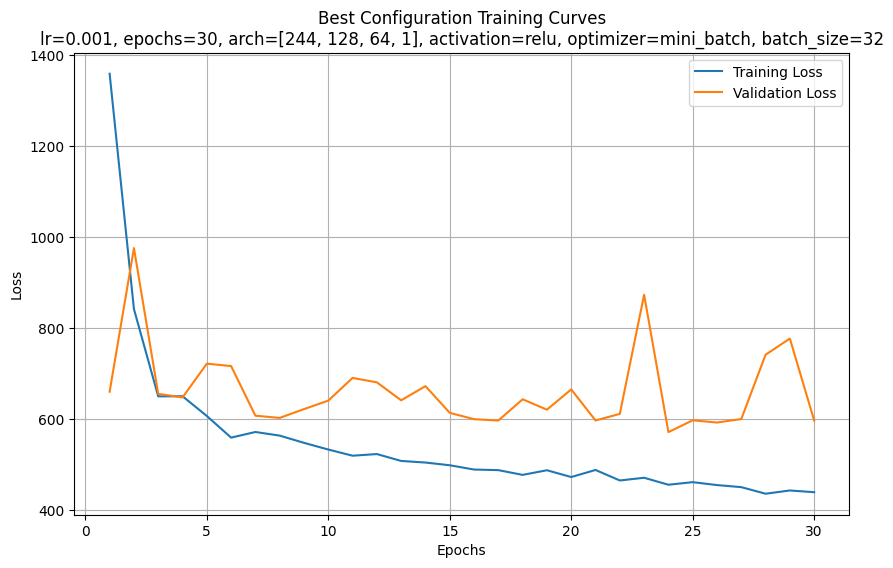

In [9]:
# Plot training curves for the best configuration
plt.figure(figsize=(10, 6))
plt.plot(range(1, best_config['Epochs'] + 1), best_config['Loss History'], label='Training Loss')
plt.plot(range(1, best_config['Epochs'] + 1), best_config['Val Loss History'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Best Configuration Training Curves\nlr={best_config["Learning Rate"]}, epochs={best_config["Epochs"]}, arch={best_config["Architecture"]}, activation={best_config["Activation"]}, optimizer={best_config["Optimizer"]}, batch_size={best_config["Batch Size"]}')
plt.legend()
plt.grid()
plt.show()

In [10]:
# Generate a report
report = pd.DataFrame(results)
report = report.sort_values(by='MSE')
print("Hyperparameter Tuning Report:")
print(report)
#save the report
report.to_csv('report.csv', index=False)

Hyperparameter Tuning Report:
    Learning Rate  Epochs       Architecture Activation   Optimizer  \
29          0.001      30  [244, 128, 64, 1]       relu  mini_batch   
38          0.010      20       [244, 64, 1]       relu  mini_batch   
2           0.001      20       [244, 64, 1]       relu  mini_batch   
56          0.010      30       [244, 64, 1]       relu  mini_batch   
20          0.001      30       [244, 64, 1]       relu  mini_batch   
..            ...     ...                ...        ...         ...   
46          0.010      20  [244, 128, 64, 1]       relu       batch   
45          0.010      20  [244, 128, 64, 1]       relu         sgd   
54          0.010      30       [244, 64, 1]       relu         sgd   
63          0.010      30  [244, 128, 64, 1]       relu         sgd   
9           0.001      20  [244, 128, 64, 1]       relu         sgd   

    Batch Size          MSE       RMSE        R²  \
29          32   563.718777  23.742763  0.636785   
38          3